# Example FlowSOM Pipeline

This vignette describes a protocol for analyzing high-dimensional cytometry 
data using FlowSOM, a clustering and visualization algorithm based 
on a self-organizing map (SOM). FlowSOM is used to distinguish cell populations
from cytometry data in an unsupervised way and can help to gain deeper insights
in fields such as immunology and oncology. 

## Loading in the data
FlowSOM handles different inputs, such as an anndata object by pytometry or a filepath. For this purpose we will make use of an anndata object. This allows
easier preprocessing. 

In [36]:
# Import modules
import flowsom as fs
import pytometry as pm
import scanpy as sc
import csv
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# Load data
ff = fs.io.read_FCS("../../tests/data/not_preprocessed.fcs")
ff

AnnData object with n_obs × n_vars = 19225 × 18
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'
    uns: 'meta'

We can get an overview of the most important data in our anndata object by using `var`. All the metadata is stored in a dictionary at `ff.uns["meta]`

In [38]:
ff.var

,n,channel,marker,$PnB,$PnE,$PnG,$PnR,$PnV
Time,1,Time,,32,"0,0",0.01,262144,
FSC-A,2,FSC-A,,32,"0,0",1.0,262144,280
FSC-H,3,FSC-H,,32,"0,0",1.0,262144,280
FSC-W,4,FSC-W,,32,"0,0",1.0,262144,280
SSC-A,5,SSC-A,,32,"0,0",1.0,262144,280
SSC-H,6,SSC-H,,32,"0,0",1.0,262144,280
SSC-W,7,SSC-W,,32,"0,0",1.0,262144,280
GFP,8,FITC-A,GFP,32,"0,0",1.0,262144,412
CD8,9,Pacific Blue-A,CD8,32,"0,0",1.0,262144,417
l/d,10,AmCyan-A,l/d,32,"0,0",1.0,262144,496


In [39]:
ff.uns["meta"].keys()

dict_keys(['__header__', '$BEGINANALYSIS', '$BEGINDATA', '$BEGINSTEXT', '$BTIM', '$BYTEORD', '$DATATYPE', '$DATE', '$ENDANALYSIS', '$ENDDATA', '$ENDSTEXT', '$ETIM', '$FIL', '$INST', '$MODE', '$NEXTDATA', '$PAR', '$SRC', '$SYS', '$TIMESTEP', '$TOT', 'APPLY COMPENSATION', 'AUTOBS', 'CREATOR', 'EXPERIMENT NAME', 'EXPORT TIME', 'EXPORT USER NAME', 'FCSversion', 'FILENAME', 'flowCore_$P10Rmax', 'flowCore_$P10Rmin', 'flowCore_$P11Rmax', 'flowCore_$P11Rmin', 'flowCore_$P12Rmax', 'flowCore_$P12Rmin', 'flowCore_$P13Rmax', 'flowCore_$P13Rmin', 'flowCore_$P14Rmax', 'flowCore_$P14Rmin', 'flowCore_$P15Rmax', 'flowCore_$P15Rmin', 'flowCore_$P16Rmax', 'flowCore_$P16Rmin', 'flowCore_$P17Rmax', 'flowCore_$P17Rmin', 'flowCore_$P18Rmax', 'flowCore_$P18Rmin', 'flowCore_$P1Rmax', 'flowCore_$P1Rmin', 'flowCore_$P2Rmax', 'flowCore_$P2Rmin', 'flowCore_$P3Rmax', 'flowCore_$P3Rmin', 'flowCore_$P4Rmax', 'flowCore_$P4Rmin', 'flowCore_$P5Rmax', 'flowCore_$P5Rmin', 'flowCore_$P6Rmax', 'flowCore_$P6Rmin', 'flowCore_

Additionaly we can read in a csv file as well.

In [40]:
ff_csv = fs.io.read_csv("../../tests/data/fcs.csv")
ff_csv

AnnData object with n_obs × n_vars = 19225 × 18
    var: 'n', 'channel', 'marker'

The `FlowSOM` function accepts an anndata object or a filepath to a fcs or csv file. The `FlowSOM` function will return a `FlowSOM` mudata object. This object contains all the information about the SOM and the clustering.

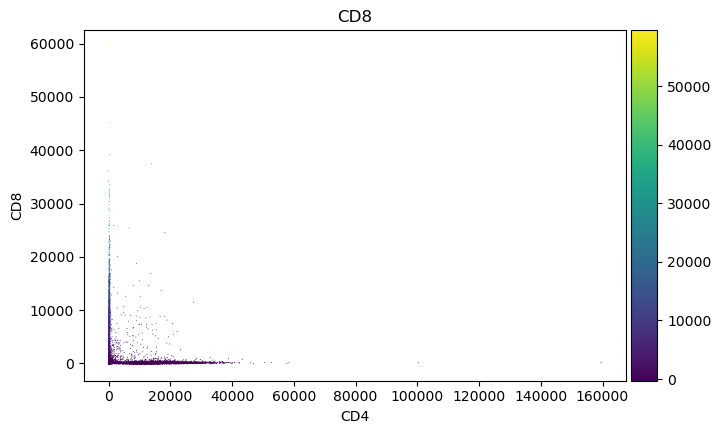

In [41]:
# Visualize data
sc.pl.scatter(ff, x="CD4", y="CD8", color="CD8", size=2)

## Preprocessing
We start with compensating the data and then we transform 
the data with the logicle function. For CyTOF data an arcsinh transformation is 
preferred which is also found in the pytometry package. Besides 
compensation and transformation, we also recommend cleaning the data by removing
margin events and by using cleaning algorithms.

In [42]:
# Compensate
ff_comp = pm.pp.compensate(ff, inplace=False)

# Transform
cols_to_use = [8, 11, 13, 14, 15, 16, 17]
ff_t = fs.pp.normalize_estimate_logicle(ff_comp, cols_to_use)

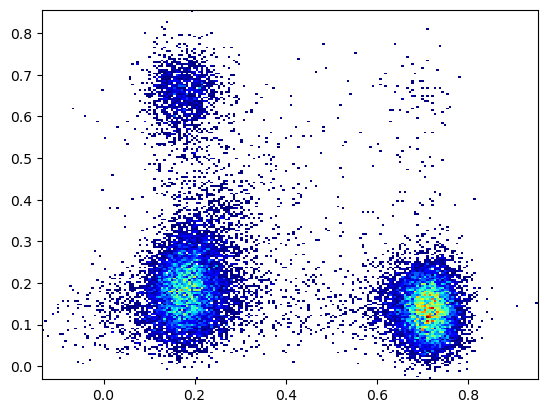

In [43]:
# Visualize data
ax = plt.hist2d(ff_t[:, "CD4"].X.flatten(), ff_t[:, "CD8"].X.flatten(), bins=200, cmin=1, cmap="jet")
plt.show()

# FlowSOM
The easiest way to use this package is using the wrapper function 
FlowSOM. It has less options than using the separate functions, 
but in general it has enough power. It returns a mudata object, of which the first
modality is the cell data and the second modality is the cluster data. We will
cluster the data with a 10 x 10 SOM grid and 10 metaclusters. Notice that due to the 
just-in-time compilation of numba, the first run of FlowSOM can take a while and 
the subsequent runs will be much faster.

In [44]:
fsom = fs.FlowSOM(ff_t, cols_to_use, xdim=10, ydim=10, n_clus=10)
fsom.mudata

MuData object with n_obs × n_vars = 19225 × 18
  2 modalities
    cell_data:	19225 x 18
      obs:	'clustering', 'distance_to_bmu', 'metaclustering'
      var:	'pretty_colnames', 'markers', 'channels', 'cols_used'
      uns:	'n_nodes', 'n_metaclusters'
    cluster_data:	100 x 18
      obs:	'percentages', 'metaclustering'
      uns:	'xdim', 'ydim', 'outliers', 'graph', 'metacluster_MFIs'
      obsm:	'cv_values', 'sd_values', 'mad_values', 'codes', 'grid', 'layout'

To add the a FlowSOM clustering and metaclustering to an anndata object, we use
flowsom_clustering, similar to other clustering methods in scverse. The FlowSOM
clustering and metaclustering can be found in obs and the parameters used in the
FlowSOM clustering in uns.FlowSOM

In [45]:
ff_clustered = fs.flowsom_clustering(ff_t, cols_to_use, xdim=10, ydim=10, n_clus=10)
ff_clustered

AnnData object with n_obs × n_vars = 19225 × 18
    obs: 'FlowSOM_clusters', 'FlowSOM_metaclusters'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'
    uns: 'meta', 'FlowSOM'
    layers: 'original'

We can access the cell data and the cluster data with the `get_cell_data()` and 
`get_cluster_data()` functions. 

The *cell data* is an anndata object that contains 
the original cell data. As observations, we find the clustering, metaclustering 
and distance to best matching unit per cell. In var, we find the pretty colnames,
i.e. a combination of markers and channels, the markers, the channels and a 
boolean mask of the columns used for clustering. n_nodes and n_metaclusters in
uns contain the number of clusters and metaclusters respectively.

In [46]:
fsom.get_cell_data()

AnnData object with n_obs × n_vars = 19225 × 18
    obs: 'clustering', 'distance_to_bmu', 'metaclustering'
    var: 'pretty_colnames', 'markers', 'channels', 'cols_used'
    uns: 'n_nodes', 'n_metaclusters'

The *cluster data* contains the original median values per cluster per marker. 
In obsm, we find the cv values, sd values, mad values, coordinates of the nodes, 
coordinates of the the grid and the coordinates of the MST layout. 
The xdim, ydim, outliers, igraph object and metacluster MFIs can be found in uns.

In [47]:
fsom.get_cluster_data()

AnnData object with n_obs × n_vars = 100 × 18
    obs: 'percentages', 'metaclustering'
    uns: 'xdim', 'ydim', 'outliers', 'graph', 'metacluster_MFIs'
    obsm: 'cv_values', 'sd_values', 'mad_values', 'codes', 'grid', 'layout'

## FlowSOM visualizations
A FlowSOM object can be visualized with the `plot_stars()` function

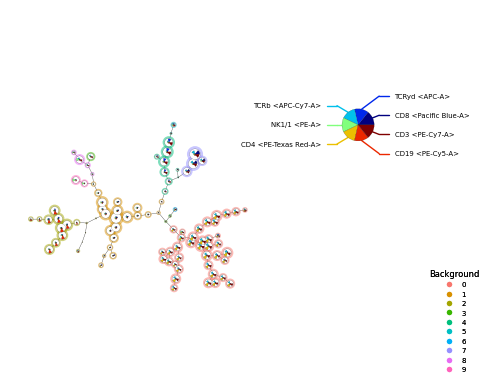

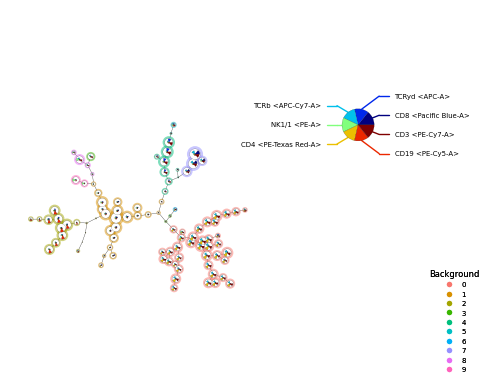

In [48]:
p = fs.pl.plot_stars(fsom, background_values=fsom.get_cluster_data().obs.metaclustering)
p.show()

We can also visualize the grid, to reduce overlap and get a better view of the data. 
The node sizes of the nodes and/or the background nodes can be made equal with the equal_node_size or equal_background_size argument

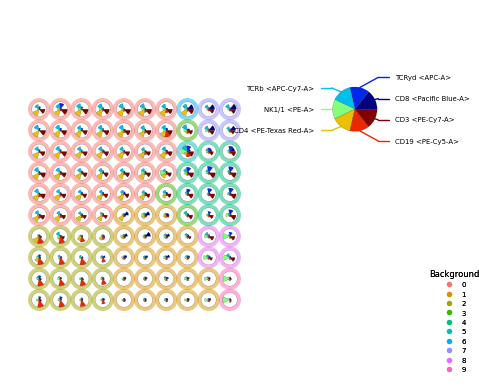

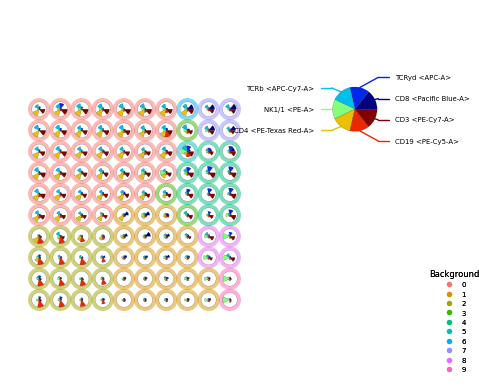

In [49]:
p = fs.pl.plot_stars(
    fsom,
    background_values=fsom.get_cluster_data().obs.metaclustering,
    view="grid",
    equal_node_size=True,
    equal_background_size=True,
)
p

If you have a label for every cell, we can visualize this with `plot_pies()`. 
Here every node is a piechart with the percentage of cells in each cluster.

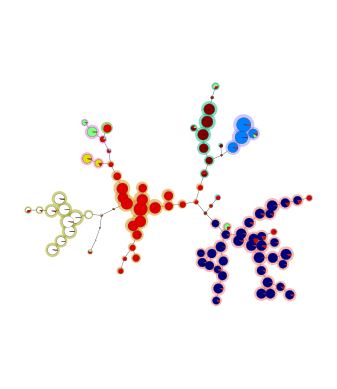

In [50]:
# Read in that data
file = open("../../tests/data/gating_result.csv")
data = csv.reader(file)
data = [i[0] for i in data]

# Plot
p = fs.pl.plot_pies(fsom, data, background_values=fsom.get_cluster_data().obs.metaclustering)

We can also visualize the cluster numbers or metacluster numbers with the help of
`plot_numbers()`, if `level="clusters"` or `level="metaclusters"`, respectively. 
This functions uses `plot_labels()` internally, to which one can pass custom labels,
such as the cell type labels.

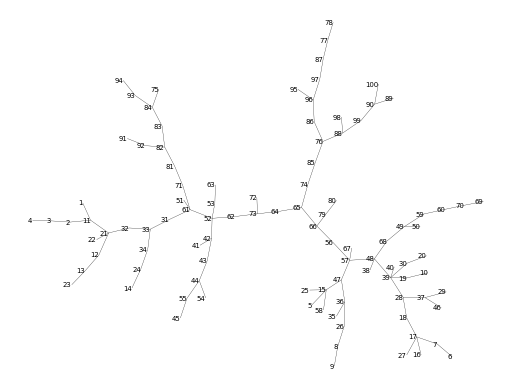

In [51]:
p = fs.pl.plot_numbers(fsom, level="clusters", text_size=5)

It is possible to visualize one marker on a FlowSOM tree with the `plot_marker()`
function. This function uses the `plot_variable()` function internally, to which
one can pass custom variables, such as the cell type labels.

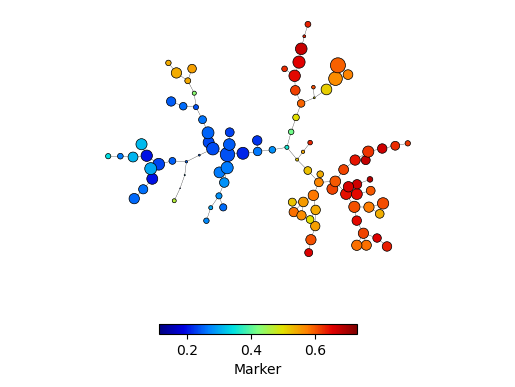

In [52]:
p = fs.pl.plot_marker(fsom, marker=np.array(["CD3"]))

We can also visualize the clusters and metaclusters on a 2D scatter plot with
`plot_2D_scatters()`.

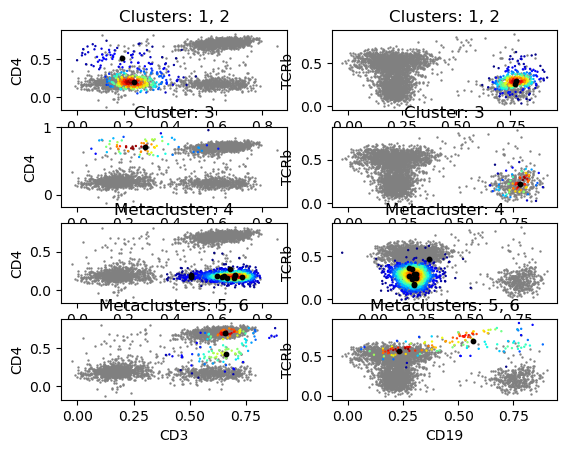

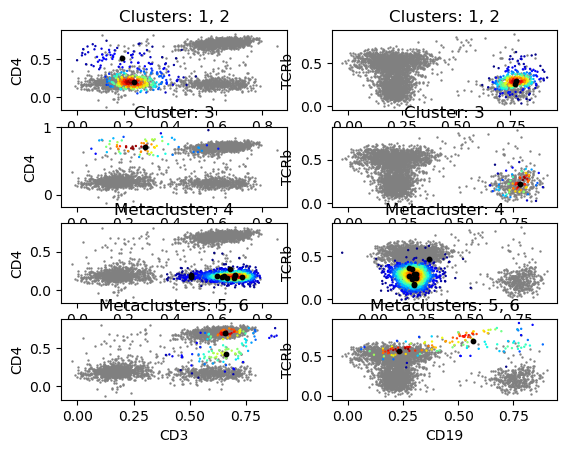

In [53]:
p = fs.pl.plot_2D_scatters(
    fsom,
    channelpairs=[["CD3", "CD4"], ["CD19", "TCRb"]],
    clusters=[[1, 2], [3]],
    metaclusters=[[4], [5, 6]],
    density=True,
    centers=True,
)
p.show()

# Downstream analysis
We might need the percentages, counts or the percentages
of positive cells per cluster or metacluster and per file for further analysis. 
This can be done with the `get_features()` function. This function returns a
dictionary containing pandas of the requested data. 

In [54]:
features = fs.tl.get_features(
    fsom,
    files=[ff_t[1:1000, :], ff_t[1000:2000, :]],
    level=["clusters", "metaclusters"],
    type=["counts", "percentages"],
)
features["metacluster_percentages"]

D:\PhD\FlowSOM_Python\src\flowsom\main.py:202: RuntimeWarning: Mean of empty slice
  means = np.nanmean(cluster_data, axis=0)
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\PhD\FlowSOM_Python\src\flowsom\main.py:202: RuntimeWarning: Mean of empty slice
  means = np.nanmean(cluster_data, axis=0)
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,MC0,MC1,MC2,MC3,MC4,MC5,MC6,MC7,MC8,MC9
0,0.396396,0.238238,0.14014,0.012012,0.09009,0.002002,0.003003,0.082082,0.015015,0.021021
1,0.404000,0.216000,0.13400,0.014000,0.08800,0.004000,0.002000,0.103000,0.017000,0.018000


The counts, percentages, percentages_positive, per cluster or metacluser can also 
extracted from a FlowSOM object. For this we can use `get_counts()`, `get_percentages()`, 
`get_cluster_percentages_positive()` or `get_metacluster_percentages_positive`, respectively.

In [55]:
fs.tl.get_counts(fsom, level="clusters")

,counts
C0,292
C1,234
C2,77
C3,66
C4,209
...,...
C95,311
C96,352
C97,31
C98,274


At last it is also possible to visualize a UMAP colored by the metaclustering or the expression of a marker. For this we will use `scanpy`.

In [56]:
# Get subset of the cell data
ref_markers_bool = fsom.get_cell_data().var["cols_used"]
subset_fsom = fsom.get_cell_data()[
    np.random.choice(range(fsom.get_cell_data().shape[0]), 5000, replace=False),
    fsom.get_cell_data().var_names[ref_markers_bool],
]
sc.pp.neighbors(subset_fsom)
sc.tl.umap(subset_fsom)

d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


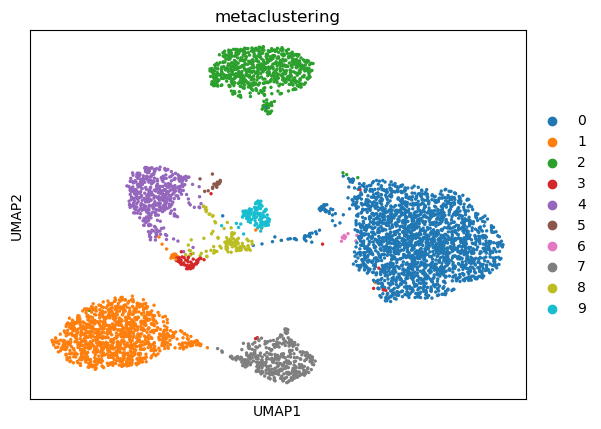

In [57]:
# By metaclustering
subset_fsom.obs["metaclustering"] = subset_fsom.obs["metaclustering"].astype(str)
sc.pl.umap(subset_fsom, color="metaclustering")

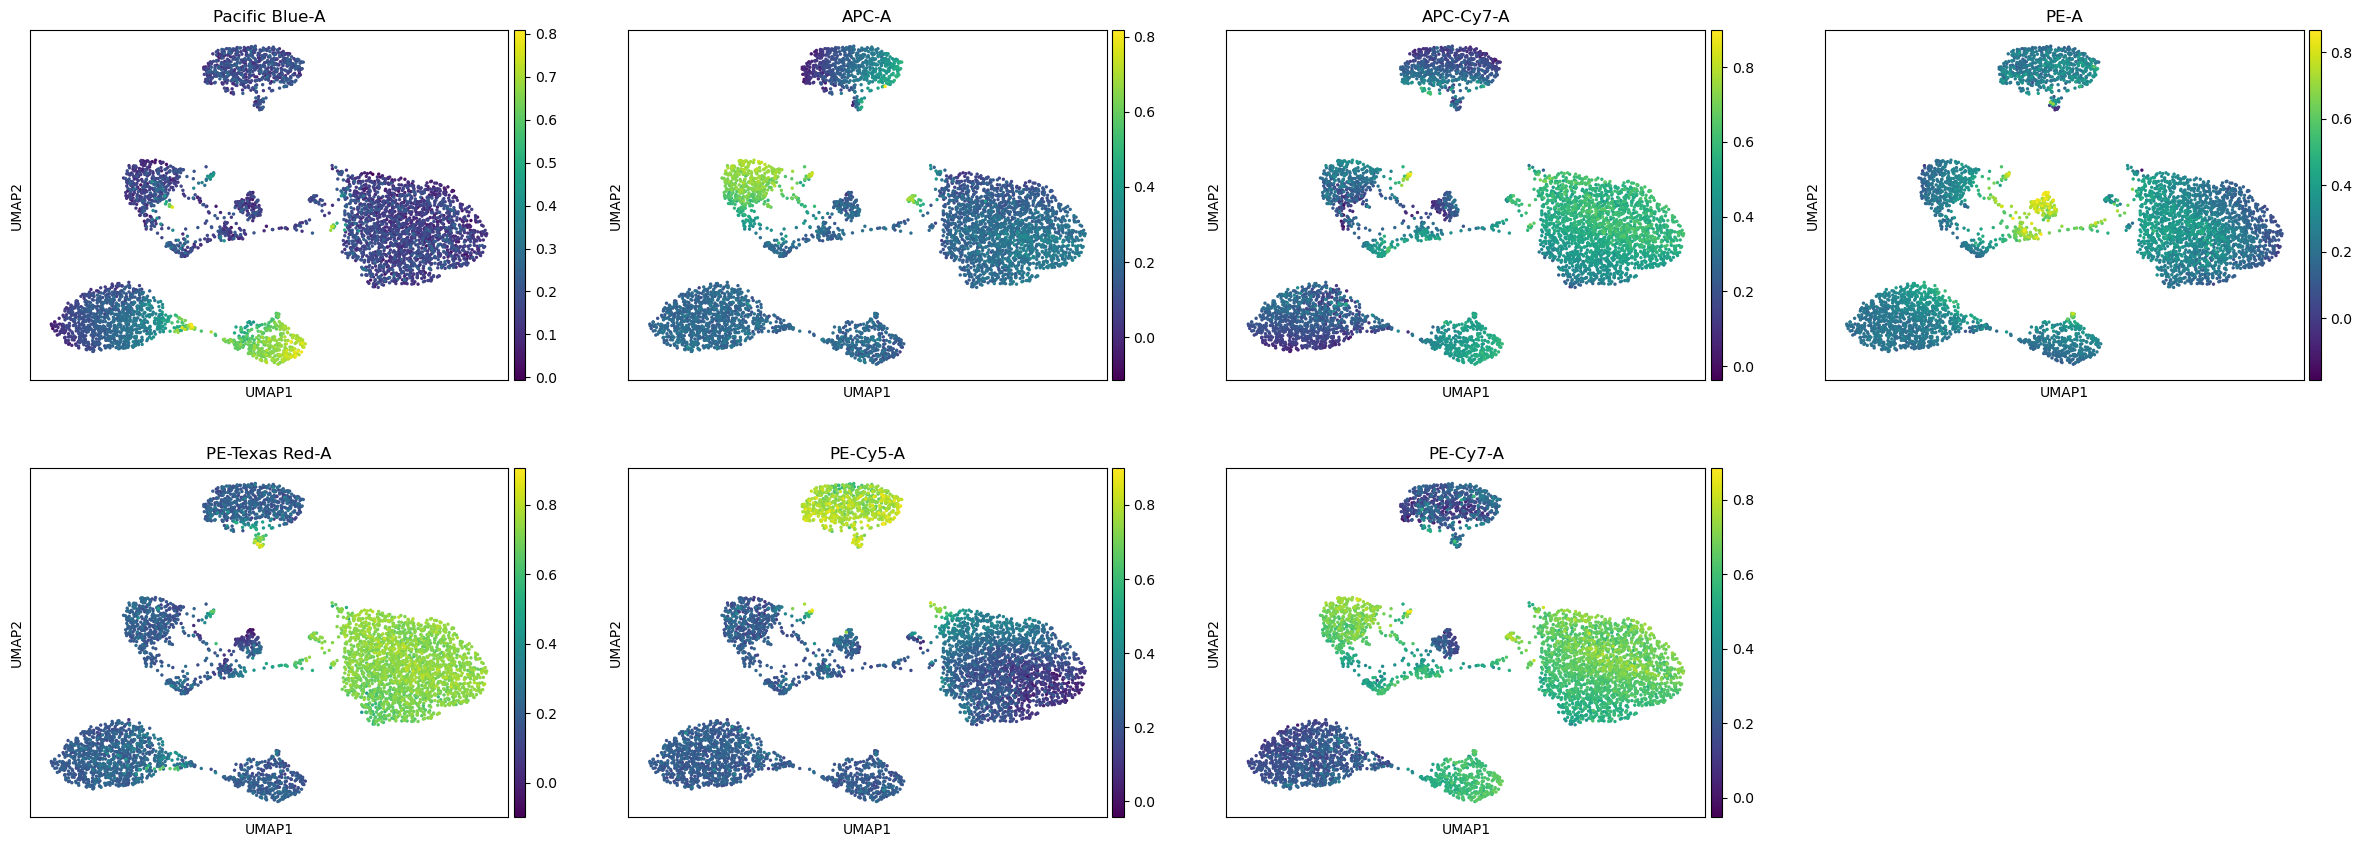

In [58]:
# By markers
sc.pl.umap(subset_fsom, color=fsom.get_cell_data().var_names[ref_markers_bool])

# Other interesting functions
To get the markers or channels from the corresponding channels or markers of an FCS or a FlowSOM object, we can use `get_markers()` or `get_channels()`.

newdata
subset


In [59]:
fs.tl.get_channels(ff_t, np.array(["CD3", "CD4"]))

{'PE-Cy7-A': 'CD3', 'PE-Texas Red-A': 'CD4'}

In [60]:
fs.tl.get_markers(fsom, np.array(["PE-A", "PE-Cy7-A"]))

{'NK1/1': 'PE-A', 'CD3': 'PE-Cy7-A'}

We can also merge multiple FCS files with random subsampling 
with the function `aggregate_flowframes()`.

In [61]:
fs.pp.aggregate_flowframes(
    filenames=["../../tests/data/not_preprocessed.fcs", "../../tests/data/not_preprocessed.fcs"], c_total=5000
)

D:\PhD\FlowSOM_Python\src\flowsom\pp\fcs_functions.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs["Original_ID"] = np.array(ids, dtype=np.float32)
D:\PhD\FlowSOM_Python\src\flowsom\pp\fcs_functions.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs["Original_ID"] = np.array(ids, dtype=np.float32)
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5000 × 18
    obs: 'Original_ID', 'File', 'File_scattered'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'

To map new data on an existing FlowSOM object, we can use the `new_data()` function.

D:\PhD\FlowSOM_Python\src\flowsom\main.py:202: RuntimeWarning: Mean of empty slice
  means = np.nanmean(cluster_data, axis=0)
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\PhD\FlowSOM_Python\src\flowsom\main.py:202: RuntimeWarning: Mean of empty slice
  means = np.nanmean(cluster_data, axis=0)
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\PhD\FlowSOM_Python\src\flowsom\main.py:202: RuntimeWarning: Mean of empty slice
  means = np.nanmean(cluster_data, axis=0)
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


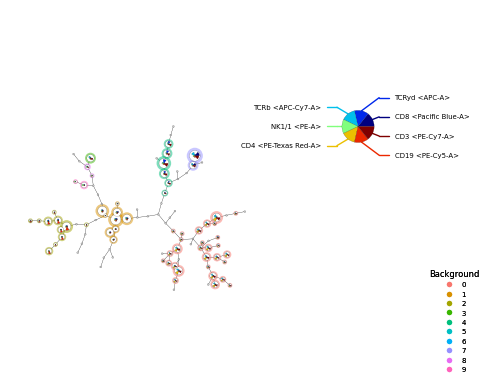

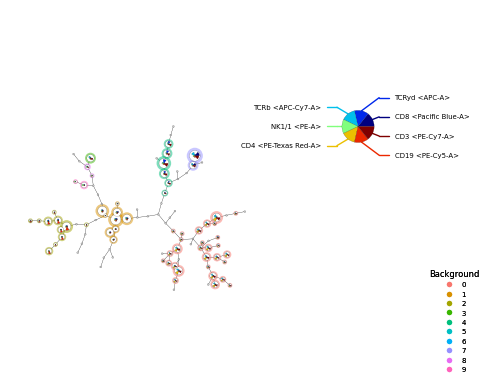

In [62]:
fsom_new = fsom.new_data(ff_t[1:200, :])
fs.pl.plot_stars(fsom_new, background_values=fsom_new.get_cluster_data().obs.metaclustering)

We can also take a subset of a FlowSOM object. For this we use the `subset()` function.

D:\PhD\FlowSOM_Python\src\flowsom\main.py:202: RuntimeWarning: Mean of empty slice
  means = np.nanmean(cluster_data, axis=0)
d:\Programs\miniconda\envs\flowsom_test\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


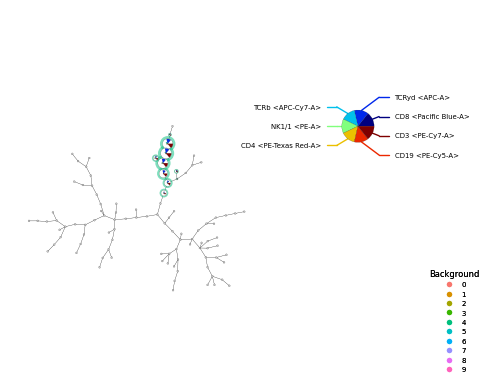

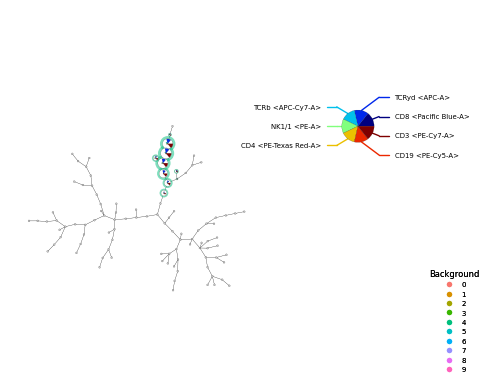

In [63]:
fsom_subset = fsom.subset(fsom.get_cell_data().obs["metaclustering"] == 4)
fs.pl.plot_stars(fsom_subset, background_values=fsom_subset.get_cluster_data().obs.metaclustering)